## NFL Object Detection

Dataset Source: https://huggingface.co/datasets/keremberke/nfl-object-detection

##### Install Necessary Libraries Not Already Installed

In [ ]:
%pip install tensorboard albumentations timm torch torchvision
%pip install transformers datasets evaluate tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.9 MB/s eta 0:00:0

##### Import Necessary Libraries

In [ ]:
import os, sys, json

import numpy as np

from tqdm import tqdm

import albumentations

from PIL import ImageDraw #, Image
import PIL.Image
from IPython.display import display

import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from transformers import TrainingArguments, Trainer

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

from datasets import *
from datasets import load_dataset

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### HuggingFace Access

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


##### Display Versions of Relevant Libraries

In [ ]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
  Transformers: 4.27.1
         Torch: 1.13.1+cu116
  Torch Vision: 0.14.1+cu116
      Evaluate: 0.4.0


#### Load Dataset

In [ ]:
ds = load_dataset("keremberke/nfl-object-detection", name="full")

ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset nfl-object-detection downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___nfl-object-detection/full/1.0.0/11e21708b0046d5aa8ea2e73faa732288ab1decf7fb98c323e38c84392229d0e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6963
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1989
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 995
    })
})

#### Show Information About Dataset(s)

In [ ]:
print("Training Dataset")
print(ds['train'])
print("Features: ", ds['train'].features)
print("First Entry:", ds['train'][0])
print("Last Entry:", ds['train'][-1])

print("\nTesting Dataset")
print(ds['test'])
print("Features: ", ds['test'].features)
print("First Entry:", ds['test'][0])
print("Last Entry:", ds['test'][-1])

print("\nEvaluation Dataset")
print(ds['validation'])
print("Features: ", ds['validation'].features)
print("First Entry:", ds['validation'][0])
print("Last Entry:", ds['validation'][-1])

Training Dataset
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 6963
})
Features:  {'image_id': Value(dtype='int64', id=None), 'image': Image(decode=True, id=None), 'width': Value(dtype='int32', id=None), 'height': Value(dtype='int32', id=None), 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['helmet', 'helmet-blurred', 'helmet-difficult', 'helmet-partial', 'helmet-sideline'], id=None)}, length=-1, id=None)}
First Entry: {'image_id': 281, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F6D5D0A3BE0>, 'width': 1280, 'height': 720, 'objects': {'id': [5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456], '

##### Visualize Example

{0: 'helmet', 1: 'helmet-blurred', 2: 'helmet-difficult', 3: 'helmet-partial', 4: 'helmet-sideline'}
{'helmet': 0, 'helmet-blurred': 1, 'helmet-difficult': 2, 'helmet-partial': 3, 'helmet-sideline': 4}


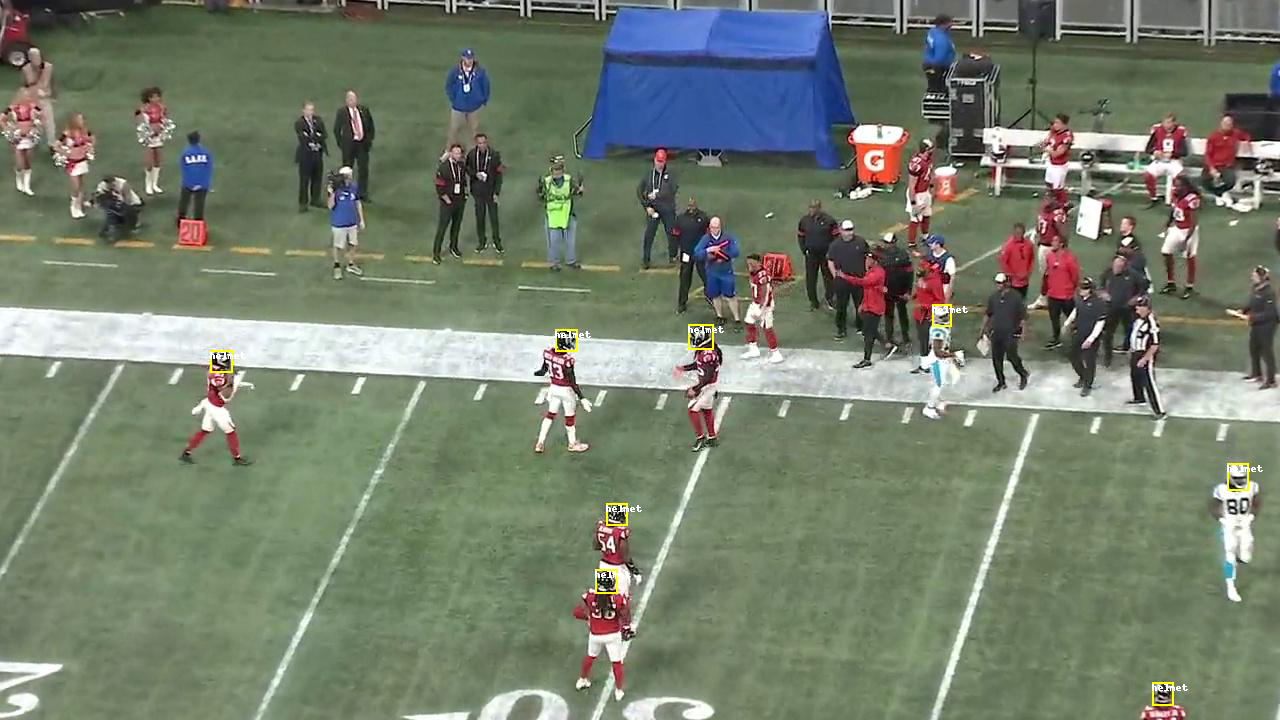

In [ ]:
image = ds['train'][12]['image']

annoations = ds['train'][12]['objects']

draw = ImageDraw.Draw(image)

categories = ds["train"].features["objects"].feature["category"].names

id2label = {k: v for k, v in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

print(id2label)
print(label2id)

for i in range(len(annoations["id"])):
    box = annoations["bbox"][i - 1]
    class_idx = annoations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=2)
    draw.text((x, y), id2label[class_idx], fill="white")

image

#### Basic Values/Constants

In [ ]:
MODEL_CKPT = "facebook/detr-resnet-50"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-NFL_Object_Detection"

LEARNING_RATE = 1e-5
NUM_OF_EPOCHS = 12

WEIGHT_DECAY = 1e-4
STRATEGY = "epoch"

BATCH_SIZE = 12
REPORTS_TO = "tensorboard"

##### Preprocess Data

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

#### Define Data Augmentations to Apply to Dataset

In [ ]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"])
)

#### Reformat Annotations for Image Processor Expectations

In [ ]:
def formatted_anns(image_id,
                   category,
                   area,
                   bbox):
    annotations= []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

#### Combine Image & Data Augmentations into Single Function

In [ ]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"],
                              examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image,
                        bboxes=objects["bbox"],
                        category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images,
                           annotations=targets,
                           return_tensors="pt")

#### Apply Image & Data Augmentation Function to Training Dataset

In [ ]:
ds["train"] = ds["train"].with_transform(transform_aug_ann)
ds["train"][12]

{'pixel_values': tensor([[[-0.5596, -0.5938, -0.6281,  ..., -0.9705, -1.2617, -1.4500],
          [-0.5596, -0.6109, -0.6623,  ..., -0.9705, -1.3987, -1.6727],
          [-0.5596, -0.6281, -0.7137,  ..., -0.9877, -1.6042, -2.0152],
          ...,
          [ 1.5982,  1.1529,  0.5022,  ...,  0.7419,  0.8961,  0.9988],
          [ 1.5810,  1.1358,  0.5022,  ...,  0.2111,  0.2967,  0.3481],
          [ 1.5639,  1.1358,  0.5022,  ..., -0.1314, -0.1143, -0.0972]],
 
         [[-0.2675, -0.3025, -0.3375,  ..., -0.9153, -1.1954, -1.3704],
          [-0.2675, -0.3200, -0.3725,  ..., -0.9328, -1.3354, -1.5980],
          [-0.2675, -0.3375, -0.4426,  ..., -0.9503, -1.5455, -1.9482],
          ...,
          [ 2.0784,  1.6408,  0.9755,  ...,  1.1681,  1.3256,  1.4307],
          [ 2.0609,  1.6232,  0.9755,  ...,  0.6429,  0.7304,  0.7829],
          [ 2.0434,  1.6232,  0.9755,  ...,  0.2927,  0.3277,  0.3452]],
 
         [[-0.0964, -0.1312, -0.1835,  ..., -0.4275, -0.7238, -0.9330],
          [-

#### Define Data Collator

In [ ]:
def collate_function(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values,
                                                         return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

##### Instantiate Model

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [ ]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    remove_unused_columns=False,
    fp16=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_function,
    train_dataset=ds['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/detr-resnet-50-NFL_Object_Detection into local empty directory.


##### Train Model

In [ ]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(


Step,Training Loss
1,4.351700
581,2.795200
1162,2.380300
1743,2.210500
2324,2.137800
2905,2.091000
3486,2.054300
4067,2.026400
4648,2.004800
5229,1.985400


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: 

#### Save Training Results to Repository

In [ ]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

#### Push Model to Hub (My Profile!!!!)

In [ ]:
trainer.push_to_hub()

### Evaluate Model

#### Step 1: Prepare Test Dataset: Format Annotations

In [ ]:
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)
    return annotations

#### Step 2: Save Data to Disk

In [ ]:
def save_data_annotation_file_images(data):
    output_json = {}
    path_output_data = f"{os.getcwd()}/NFL"

    if not os.path.exists(path_output_data):
        os.makedirs(path_output_data)

    path_anno = os.path.join(path_output_data, "nfl_ann.json")
    categories_json = [
        {"supercategory": "none", "id": id, "name": id2label[id]
         } for id in id2label
         ]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in data:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as f:
        json.dump(output_json, f, ensure_ascii=False, indent=4)

    for im, img_id in zip(data["image"], data["image_id"]):
        path_img = os.path.join(path_output_data, f"{img_id}.png")
        im.save(path_img)

    return path_output_data, path_anno

##### Step 3: Define CocoDetection Class

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image & target (convert target to DETR format,
        # resize + normalize both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

##### Create Instance of CocoDetection Class

In [ ]:
#INFERENCE_MODEL = MODEL_NAME
INFERENCE_MODEL = MODEL_CKPT

img_processor = AutoImageProcessor.from_pretrained(INFERENCE_MODEL)

path_output_data, path_anno = save_data_annotation_file_images(ds["test"])
test_ds_coco_format = CocoDetection(path_output_data,
                                    img_processor,
                                    path_anno)

##### Step 4: Load Metrics

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(INFERENCE_MODEL)
module = evaluate.load("ybelkada/cocoevaluate",
                       coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_function
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        outputs = model(pixel_values=pixel_values,
                        pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack(
            [target["orig_size"] for target in labels], dim=0)

        results = img_processor.post_process(outputs,
                                             orig_target_sizes)

        module.add(prediction=results,
                   reference=labels)
        del batch


##### Save, Log, & Show Metrics

In [ ]:
eval_results = module.compute()
print(eval_results)

trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

### Notes & Other Takeaways
****
- This project has potential. Unfortunately, it would take about five times as many training epochs to acheive the results I seek. As can be seen above, that is more than Google Colab will allow. Additionally, it would most likely take a matter of weeks to train this project locally.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2005-12872, author = {Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko}, title = {End-to-End Object Detection with Transformers}, journal = {CoRR}, volume = {abs/2005.12872}, year = {2020}, url = {https://arxiv.org/abs/2005.12872}, archivePrefix = {arXiv}, eprint = {2005.12872}, timestamp = {Thu, 28 May 2020 17:38:09 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ nfl-competition_dataset, title = { NFL-competition Dataset }, type = { Open Source Dataset }, author = { home }, howpublished = { \\url{ https://universe.roboflow.com/home-mxzv1/nfl-competition } }, url = { https://universe.roboflow.com/home-mxzv1/nfl-competition }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-01-18 },}